In [4]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import os

In [5]:
ticker_symbol = "SOL-USD"

# Define the period (past two years)
if not os.path.exists("./solana_prices2.csv"):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=4*365)

    # Fetch the historical data
    solana_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1d')

    # Display the data
    print(solana_data)

    # Save the data to a CSV file
    solana_data.to_csv("solana_prices.csv")

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-05-31    0.587903    0.593997    0.569245    0.570022    0.570022   
2020-06-01    0.573472    0.587839    0.567348    0.577495    0.577495   
2020-06-02    0.577142    0.589725    0.552294    0.564669    0.564669   
2020-06-03    0.564669    0.591025    0.564461    0.586621    0.586621   
2020-06-04    0.586867    0.591640    0.564518    0.587299    0.587299   
...                ...         ...         ...         ...         ...   
2024-05-25  167.796921  170.355057  166.113007  168.437637  168.437637   
2024-05-26  168.437637  168.439270  161.263870  163.350906  163.350906   
2024-05-27  163.350906  171.988541  163.335449  169.996140  169.996140   
2024-05-28  169.996140  173.017136  164.973404  168.650848  168.650848   
2024-05-29  168.650848  173.641953  167.323853  168.072678  168.072678   

                Volume  
Date        

In [12]:
df = pd.read_csv('./solana_prices.csv', parse_dates=['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1460 non-null   datetime64[ns]
 1   Open       1460 non-null   float64       
 2   High       1460 non-null   float64       
 3   Low        1460 non-null   float64       
 4   Close      1460 non-null   float64       
 5   Adj Close  1460 non-null   float64       
 6   Volume     1460 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 80.0 KB


In [46]:
df.head()
df.sort_values(['Date'], ascending=False)

,Date,Open,High,Low,Close,Adj Close,Volume,Label
1369,2024-02-29,118.238747,134.465698,117.667519,125.711517,125.711517,6950123902,buy
1368,2024-02-28,108.399239,118.052200,107.460876,118.052200,118.052200,5029492553,buy
1367,2024-02-27,109.918785,112.204712,105.896935,108.388084,108.388084,2723995106,buy
1366,2024-02-26,103.450706,110.580353,100.455200,109.918533,109.918533,2334408023,buy
1365,2024-02-25,104.132668,104.329941,102.171028,103.453491,103.453491,909662462,buy
...,...,...,...,...,...,...,...,...
4,2020-06-04,0.586867,0.591640,0.564518,0.587299,0.587299,901641,buy
3,2020-06-03,0.564669,0.591025,0.564461,0.586621,0.586621,877446,buy
2,2020-06-02,0.577142,0.589725,0.552294,0.564669,0.564669,1295757,buy
1,2020-06-01,0.573472,0.587839,0.567348,0.577495,0.577495,2159877,buy


In [15]:
def create_dynamic_labels(data, min_days=5, max_days=30, threshold=0.05):
    """
    Creates labels based on future price changes over a dynamic range of days.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Close' column.
    min_days (int): Minimum number of days to look into the future.
    max_days (int): Maximum number of days to look into the future.
    threshold (float): Threshold for price change to label 'buy', 'sell', or 'hold'.
    
    Returns:
    pd.DataFrame: DataFrame with 'Label' column.
    """
    # Ensure the DataFrame has a 'Close' column
    if 'Close' not in data.columns:
        raise ValueError("DataFrame must contain a 'Close' column")
    
    # Initialize the label column
    data['Label'] = 'hold'
    
    # Iterate over the range of future days
    for future_days in range(min_days, max_days + 1):
        # Calculate future price change
        data['Future_Close'] = data['Close'].shift(-future_days)
        data['Price_Change'] = (data['Future_Close'] - data['Close']) / data['Close']
        
        # Create labels based on price change
        data.loc[data['Price_Change'] >= threshold, 'Label'] = 'buy'
        data.loc[data['Price_Change'] <= -threshold, 'Label'] = 'sell'
    
    # Drop rows with NaN values in 'Future_Close' (these are the last 'max_days' rows)
    data.dropna(subset=['Future_Close'], inplace=True)
    
    # Drop the 'Future_Close' and 'Price_Change' columns
    data.drop(columns=['Future_Close', 'Price_Change'], inplace=True)
    
    return data

In [18]:
df = create_dynamic_labels(df)
df.sample()

,Date,Open,High,Low,Close,Adj Close,Volume,Label
784,2022-07-24,40.038811,42.021122,39.605618,41.006584,41.006584,1115260733,sell


In [29]:
import matplotlib.pyplot as plt

def plot_stock_data(data, ticker_symbol):
    plt.figure(figsize=(14, 7))
    
    # Plot closing prices
    plt.plot(data['Date'], data['Close'], label='Close Price', color='blue', alpha=0.5)
    
    # Plot buy signals
    buy_signals = data[data['Label'] == 'buy']
    plt.scatter(buy_signals['Date'], buy_signals['Close'], label='Buy Signal', marker='^', color='green', alpha=1)

    # Plot sell signals
    sell_signals = data[data['Label'] == 'sell']
    plt.scatter(sell_signals['Date'], sell_signals['Close'], label='Sell Signal', marker='v', color='red', alpha=1)

    # Title and labels
    plt.title(f'{ticker_symbol} Stock Price and Trading Signals')
    plt.xlabel('Date')
    plt.ylabel('Close Price (USD)')
    plt.legend()
    plt.grid(True)

    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator())
    plt.xticks(rotation=45)

    plt.show()

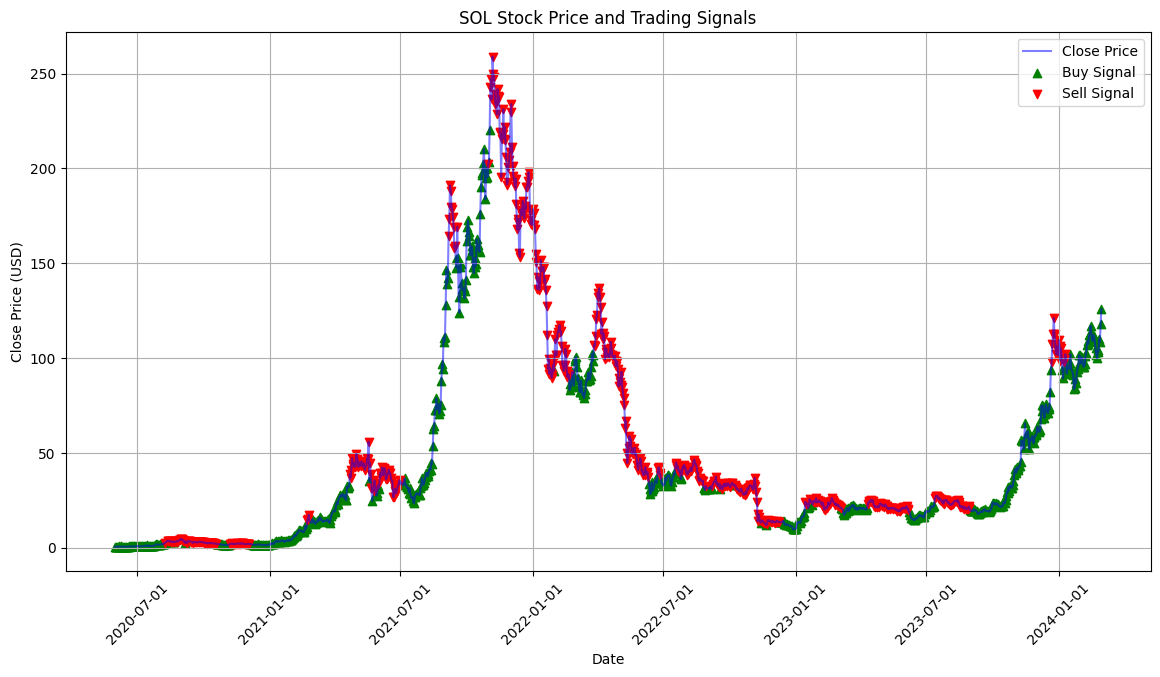

In [30]:
plot_stock_data(df, 'SOL')